# **Import necessary libraries**

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.interpolation import map_coordinates

# **Load cifar100 datasets**

In [2]:
(full_train_x, full_train_y), (test_x, test_y) = keras.datasets.cifar100.load_data()
full_train_x.shape, full_train_y.shape, test_x.shape, test_y.shape

169017344/169001437 [==============================] - 12s 0us/step


((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

In [3]:
np.unique(full_train_y)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [4]:
full_train_y[0]

array([19])

# **Create cross-validation set**

In [5]:
train_x, val_x, train_y, val_y = train_test_split(full_train_x, full_train_y, test_size = 0.2)
train_x.shape, val_x.shape, train_y.shape, val_y.shape

((40000, 32, 32, 3), (10000, 32, 32, 3), (40000, 1), (10000, 1))

# **Normalize data**

In [6]:
train_x.shape, val_x.shape, train_x[0].shape, val_x[0].shape

((40000, 32, 32, 3), (10000, 32, 32, 3), (32, 32, 3), (32, 32, 3))

In [7]:
train_y = keras.utils.to_categorical(train_y)
val_y = keras.utils.to_categorical(val_y)
test_y = keras.utils.to_categorical(test_y)

In [8]:
train_y[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

# **Labels**

In [9]:
labels = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

# **Data augmentation**

In [ ]:
def elastic_transform(image, alpha_range, sigma, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_.
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
       Convolutional Neural Networks applied to Visual Document Analysis", in
       Proc. of the International Conference on Document Analysis and
       Recognition, 2003.
       
   # Arguments
       image: Numpy array with shape (height, width, channels). 
       alpha_range: Float for fixed value or [lower, upper] for random value from uniform distribution.
           Controls intensity of deformation.
       sigma: Float, sigma of gaussian filter that smooths the displacement fields.
       random_state: `numpy.random.RandomState` object for generating displacement fields.
    """
    
    if random_state is None:
        random_state = np.random.RandomState(None)
        
    if np.isscalar(alpha_range):
        alpha = alpha_range
    else:
        alpha = np.random.uniform(low=alpha_range[0], high=alpha_range[1])

    shape = image.shape
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha

    x, y, z = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), np.arange(shape[2]), indexing='ij')
    indices = np.reshape(x+dx, (-1, 1)), np.reshape(y+dy, (-1, 1)), np.reshape(z, (-1, 1))

    return map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)

In [11]:
# Train datagen
train_datagen = ImageDataGenerator(
        horizontal_flip = True,
        featurewise_center = True,
        featurewise_std_normalization = True,
)

train_datagen.fit(train_x)
train_generator = train_datagen.flow(train_x, train_y, batch_size = 128)

# Valid datagen
valid_datagen = ImageDataGenerator(
    featurewise_center = True,
    featurewise_std_normalization = True,
)

valid_datagen.fit(val_x)
valid_generator = valid_datagen.flow(val_x, val_y, batch_size = 128)

# Test datagen
test_datagen = ImageDataGenerator(
    featurewise_center = True,
    featurewise_std_normalization = True,
)

test_datagen.fit(test_x)
test_generator = test_datagen.flow(test_x, test_y, batch_size = 128)

# **Create model**

**Custom model with 3 CNNs and 1 FC**

In [12]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(128, (3, 3), padding = 'same', input_shape = (32, 32, 3), kernel_initializer = keras.initializers.HeNormal(), kernel_regularizer = keras.regularizers.l2(1e-3)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('swish'))
model.add(keras.layers.Conv2D(128, (3, 3), kernel_initializer = keras.initializers.HeNormal(), kernel_regularizer = keras.regularizers.l2(1e-3)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('swish'))
model.add(keras.layers.MaxPooling2D(strides = 2))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Conv2D(256, (3, 3), padding = 'same', kernel_initializer = keras.initializers.HeNormal(), kernel_regularizer = keras.regularizers.l2(1e-3)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('swish'))
model.add(keras.layers.Conv2D(256, (3, 3), kernel_initializer = keras.initializers.HeNormal(), kernel_regularizer = keras.regularizers.l2(1e-3)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('swish'))
model.add(keras.layers.MaxPooling2D(strides = 2))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Conv2D(512, (3, 3), padding = 'same', kernel_initializer = keras.initializers.HeNormal(), kernel_regularizer = keras.regularizers.l2(1e-3)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('swish'))
model.add(keras.layers.Conv2D(512, (3, 3), kernel_initializer = keras.initializers.HeNormal(), kernel_regularizer = keras.regularizers.l2(1e-3)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('swish'))
model.add(keras.layers.MaxPooling2D(strides = 2))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(512, kernel_initializer = keras.initializers.HeNormal(), kernel_regularizer = keras.regularizers.l2(1e-3)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(100))
model.add(keras.layers.Activation('softmax'))

**VGG Blocks**

In [13]:
weight_decay = 5e-4

In [ ]:
def vgg_block(layer_in, n_filters, dropout_rate = None, pooling = False):
  layer_in = keras.layers.Conv2D(n_filters, (3, 3), padding = 'same', kernel_regularizer = keras.regularizers.l2(weight_decay))(layer_in)
  layer_in = keras.layers.Activation('relu')(layer_in)
  layer_in = keras.layers.BatchNormalization()(layer_in)
  if pooling == True:
    layer_in = keras.layers.MaxPooling2D()(layer_in)
  if dropout_rate is not None:
    layer_in = keras.layers.Dropout(dropout_rate)(layer_in)

  return layer_in

In [ ]:
input = keras.layers.Input(shape = (32, 32, 3))
output = vgg_block(input, 64, dropout_rate = 0.3)
output = vgg_block(output, 64, pooling = True)
output = vgg_block(output, 128, dropout_rate = 0.4)
output = vgg_block(output, 128, pooling = True)
output = vgg_block(output, 256, dropout_rate = 0.4)
output = vgg_block(output, 256, dropout_rate = 0.4)
output = vgg_block(output, 256, pooling = True)
output = vgg_block(output, 512, dropout_rate = 0.4)
output = vgg_block(output, 512, dropout_rate = 0.4)
output = vgg_block(output, 512, pooling = True)
output = vgg_block(output, 512, dropout_rate = 0.4)
output = vgg_block(output, 512, dropout_rate = 0.4)
output = vgg_block(output, 512, pooling = True, dropout_rate = 0.5)
output = keras.layers.Flatten()(output)
output = keras.layers.Dense(512, kernel_regularizer = keras.regularizers.l2(weight_decay))(output)
output = keras.layers.Activation('relu')(output)
output = keras.layers.BatchNormalization()(output)
output = keras.layers.Dropout(0.5)(output)
output = keras.layers.Dense(100)(output)
output = keras.layers.Activation('softmax')(output)

model = keras.models.Model(inputs = input, outputs = output)

# **Model architecture**

In [14]:
#@title
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 128)       3584      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 128)      512       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 32, 32, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 128)       147584    
                                                                 
 batch_normalization_1 (Batc  (None, 30, 30, 128)      512       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 30, 30, 128)       0

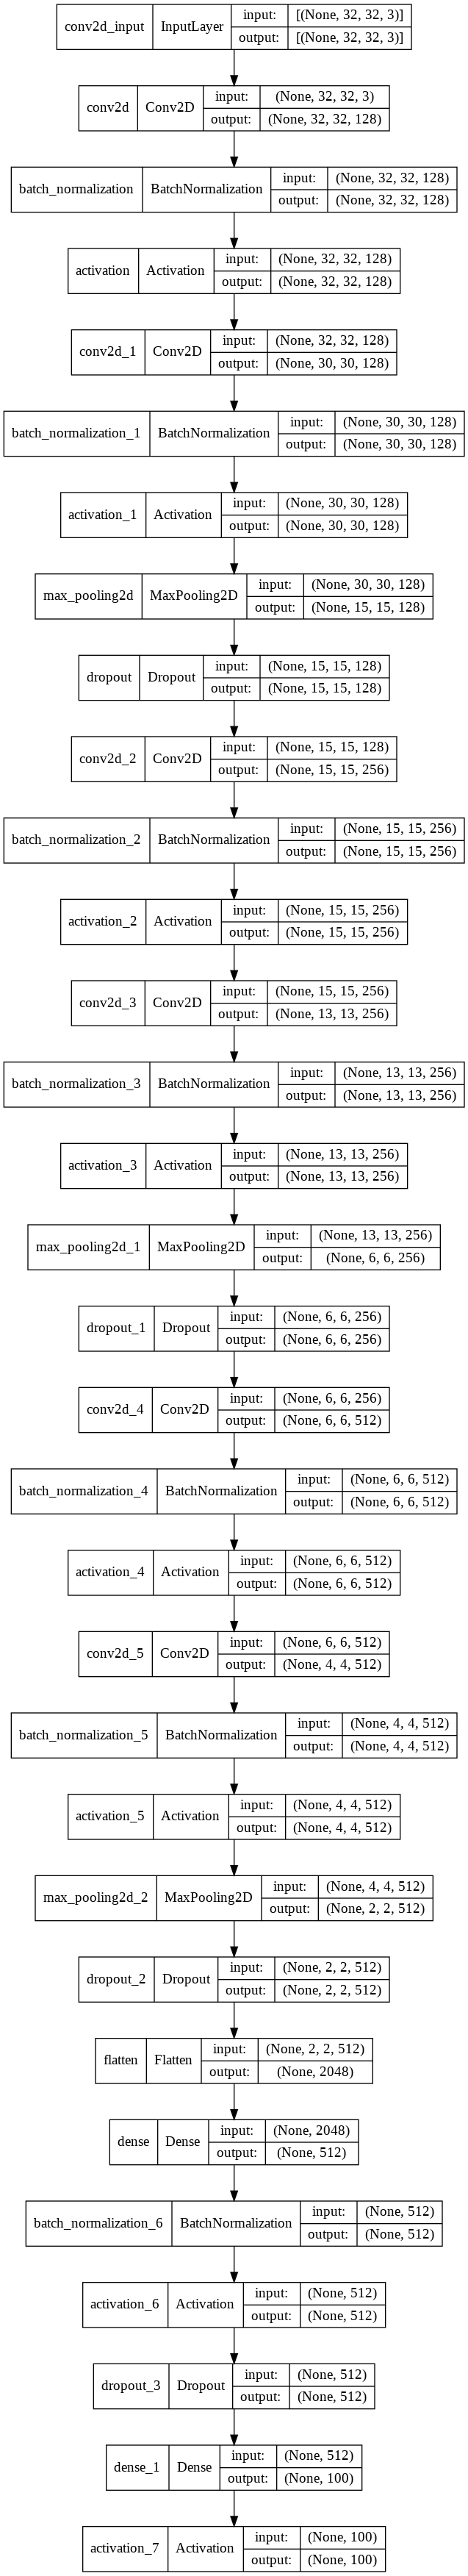

In [15]:
#@title
keras.utils.plot_model(model, show_shapes = True)

# **Compile model**

In [16]:
num_epoch = 230
batch_size = 128
learning_rate = 0.1
lr_decay = 1e-6
lr_drop = 18

In [17]:
def lr_scheduler(epoch):
  return learning_rate * (0.5 ** (epoch // lr_drop))

In [18]:
lr_scheduler_callback = keras.callbacks.LearningRateScheduler(lr_scheduler)

In [19]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = keras.optimizers.SGD(learning_rate = learning_rate, decay = lr_decay, momentum = 0.9, nesterov = True, clipvalue = 0.5),
    metrics = ['accuracy'],
)

# **Train model**

In [20]:
history = model.fit(train_generator, epochs = num_epoch, validation_data = valid_generator, batch_size = batch_size, callbacks = [lr_scheduler_callback])

Epoch 1/230
313/313 [==============================] - 63s 164ms/step - loss: 7.5574 - accuracy: 0.0669 - val_loss: 6.2147 - val_accuracy: 0.0285 - lr: 0.1000
Epoch 2/230
313/313 [==============================] - 50s 161ms/step - loss: 4.7370 - accuracy: 0.1598 - val_loss: 4.3907 - val_accuracy: 0.1766 - lr: 0.1000
Epoch 3/230
313/313 [==============================] - 50s 161ms/step - loss: 3.9401 - accuracy: 0.2294 - val_loss: 3.6601 - val_accuracy: 0.2859 - lr: 0.1000
Epoch 4/230
313/313 [==============================] - 52s 167ms/step - loss: 3.7161 - accuracy: 0.2732 - val_loss: 3.6734 - val_accuracy: 0.2967 - lr: 0.1000
Epoch 5/230
313/313 [==============================] - 51s 162ms/step - loss: 3.6451 - accuracy: 0.3022 - val_loss: 3.5084 - val_accuracy: 0.3410 - lr: 0.1000
Epoch 6/230
313/313 [==============================] - 51s 162ms/step - loss: 3.6153 - accuracy: 0.3191 - val_loss: 3.6283 - val_accuracy: 0.3314 - lr: 0.1000
Epoch 7/230
313/313 [=========================

# **Plot graph**

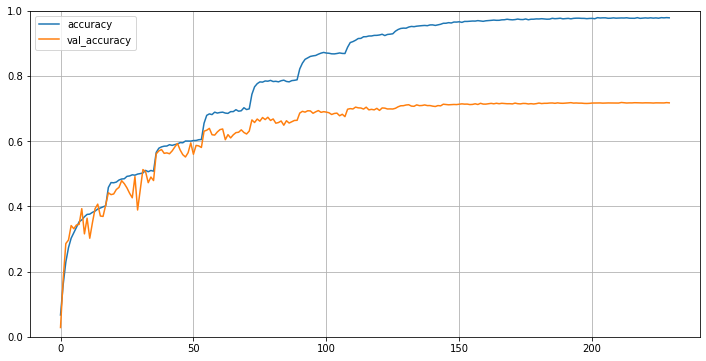

In [21]:
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot(figsize = (12, 6))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

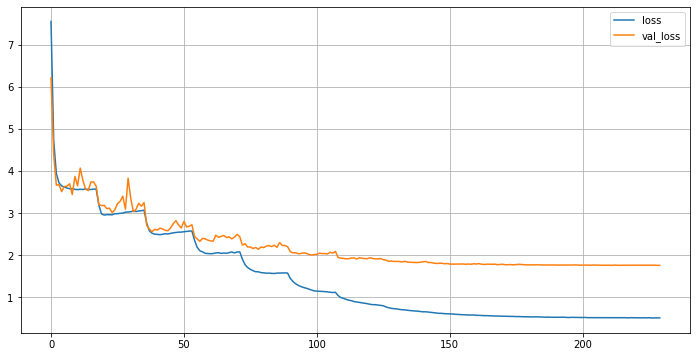

In [22]:
pd.DataFrame(history.history)[['loss', 'val_loss']].plot(figsize = (12, 6))
plt.grid(True)
plt.show()

# **Evaluate**

In [23]:
model.evaluate(test_generator)

79/79 [==============================] - 4s 47ms/step - loss: 1.7715 - accuracy: 0.7163


[1.7715293169021606, 0.7163000106811523]

In [24]:
pred_y = model.predict(test_generator)

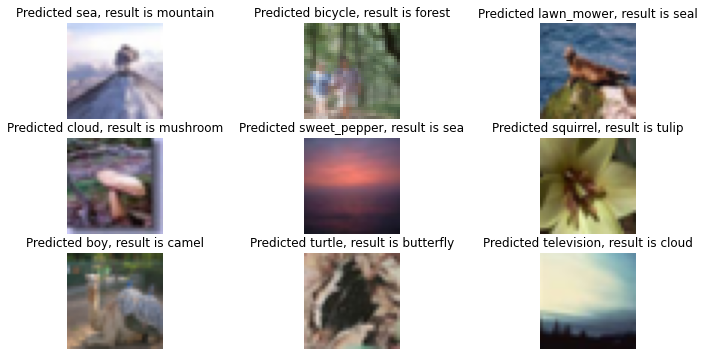

In [25]:
# Analyze 9 cases
plt.figure(figsize = (12, 6))

idx = 0
for i in range(pred_y.shape[0]):
  predicted = np.argmax(pred_y[i])
  true_label = np.argmax(test_y[i])
  if predicted != true_label:
    idx += 1
    plt.subplot(3, 3, idx)
    plt.title(f'Predicted {labels[predicted]}, result is {labels[true_label]}')
    plt.imshow(test_x[i])
    plt.axis('off')

    if idx >= 9:
      break

plt.show()